In [1]:
!pip install rdkit
!pip install networkx
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00


In [2]:
import gdown
import pandas as pd
import torch
from rdkit import Chem
from torch_geometric.data import Data, Batch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [3]:
# from google.colab import drive

# drive.mount('/content/drive')

# Load the CSV dataset
# data = pd.read_csv("/content/drive/MyDrive/CS 566/Notebooks/Updated_effectiveness.csv")
data = pd.read_csv("/content/Updated_effectiveness (1).csv")
print(data.shape)

(11931, 7)


In [4]:
data.describe()

,Unnamed: 0,Y,Target_encoded
count,11931.000000,11931.000000,11931.000000
mean,5965.000000,5.472763,7.532190
std,3444.327365,3.910242,5.849010
min,0.000000,-11.512925,0.000000
25%,2982.500000,2.451005,2.680000
50%,5965.000000,4.941642,6.133333
75%,8947.500000,8.294050,11.600000
max,11930.000000,16.118096,20.000000


In [ ]:
'''
target_id_map = data.drop_duplicates(subset=['Target', 'Target_ID'])

# Step 2: Merge this mapping with the 'Target_encoded' information
# As 'Target_encoded' should directly map from 'Target', this should be a straightforward merge
mapping_df = target_id_map[['Target', 'Target_ID']].merge(
    data[['Target', 'Target_encoded']].drop_duplicates('Target'),
    on='Target',
    how='left'
)

# Resulting DataFrame
print(mapping_df)
'''

                                                Target Target_ID  \
0    MANDSGGPGGPSPSERDRQYCELCGKMENLLRCSRCRSSFYCCKEH...    Q9GZT9   
1    MRRNIFCLACLWIVQACLSLDRADILYNIRQTSRPDVIPTQRDRPV...    P58154   
2    MQQFTIRTRLLMLVGAMFIGFITIELMGFSALQRGVASLNTVYLDR...    Q9Z429   
3    MPRSLANAPIMILNGPNLNLLGQRQPEIYGSDTLADVEALCVKAAA...    P15474   
4    MTNSTDGRADGRLRVVVLGSTGSIGTQALQVIADNPDRFEVVGLAA...    P9WNS1   
..                                                 ...       ...   
748  MVVFNGLLKIKICEAVSLKPTAWSLRHAVGPRPQTFLLDPYIALNV...    Q02156   
749  MGCIKSKGKDSLSDDGVDLKTQPVRNTERTIYVRDPTSNKQQRPVP...    P07948   
750  MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...    P06493   
751  MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGG...    P11802   
752  MELENIVANTVLLKAREGGGGKRKGKSKKWKEILKFPHISQCEDLR...    P34947   

     Target_encoded  
0          0.000000  
1          0.026667  
2          0.053333  
3          0.080000  
4          0.106667  
..              ...  
748       19.893333  
749    

In [ ]:
#mapping_df.to_csv('target_mapping.csv', index=False)

In [ ]:
#data.to_csv("Updated_effectiveness.csv")

In [5]:
def molecule_to_graph(molecule):
    num_atoms = molecule.GetNumAtoms()
    x = torch.tensor([atom_feature_vector(atom) for atom in molecule.GetAtoms()], dtype=torch.float)
    edge_index = []
    edge_attr = []
    for bond in molecule.GetBonds():
        edge_index.extend([[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()], [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]])
        edge_attr.extend([bond_feature_vector(bond), bond_feature_vector(bond)])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

def atom_feature_vector(atom):
    return [atom.GetAtomicNum(), atom.GetDegree(), atom.GetHybridization()]

def bond_feature_vector(bond):
    return [bond.GetBondTypeAsDouble(), bond.IsInRing()]

def visualize(graph):
    nx_graph = to_networkx(graph, to_undirected=True)

    fig = plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(nx_graph)

    nx.draw_networkx(nx_graph, pos, with_labels=True, node_size=500, font_size=12, font_weight='bold')

    if 'edge_attr' in next(iter(nx_graph.edges(data=True)))[-1]:
        edge_labels = {(u, v): d['edge_attr'] for u, v, d in nx_graph.edges(data=True)}
        nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=10)

    plt.axis('off')
    plt.show()

In [6]:
import numpy as np
graphs = []
indices = []

for _, row in data.iterrows():
    idx_dict = {}
    if isinstance(row['Drug'], str):
        molecule = Chem.MolFromSmiles(row['Drug'])
        graph = molecule_to_graph(molecule)

        required_feature_size = 1  # The total number of features per node

        # Create a feature vector for the "Catalyst Score" node
        # First, initialize a vector of zeros with the required_feature_size
        catalyst_score_features = torch.zeros(1, required_feature_size)
        catalyst_score_features[0, 0] = row['Y']
        # catalyst_score_features[0, 1] = row['Target_encoded']

        catalyst_score_node_index = graph.x.shape[0]

        pad_size = graph.x.shape[1] - catalyst_score_features.shape[1]
        catalyst_score_features_padded = torch.cat([catalyst_score_features,torch.zeros((catalyst_score_features.shape[0],pad_size))], dim=1)

        combined_x = torch.cat([graph.x, catalyst_score_features_padded], dim=0)

        combined_x_idx = [[], []]
        combined_x_idx[0] = np.arange(0,graph.x.shape[0]) # graph 1 node indices
        combined_x_idx[1] = np.arange(graph.x.shape[0],graph.x.shape[0]+1) # y index

        idx_dict["node"] = combined_x_idx

        additional_edge_index = torch.cat([
            torch.tensor([[i, catalyst_score_node_index] for i in range(graph.x.shape[0])])], dim=0).t().contiguous()

        additional_edge_attr = torch.ones((additional_edge_index.shape[1], graph.edge_attr.shape[1]), dtype=torch.float)

        combined_edge_index = torch.cat([graph.edge_index, additional_edge_index], dim=1)

        combined_edge_index_idx = [[], []]
        combined_edge_index_idx[0] = np.arange(0,graph.edge_index.shape[1]) # graph 1 edge index' indices
        combined_edge_index_idx[1] = np.arange(graph.edge_index.shape[1],
                            graph.edge_index.shape[1]+additional_edge_index.shape[1]) # y edge index' index


        idx_dict["edge_index"] = combined_edge_index_idx

        combined_edge_attr = torch.cat([graph.edge_attr, additional_edge_attr], dim=0)
        combined_edge_attr_idx = [[], []]
        combined_edge_attr_idx[0] = np.arange(0,graph.edge_attr.shape[0]) # graph 1 edge attr' indices
        combined_edge_attr_idx[1] = np.arange(graph.edge_attr.shape[0],
                            graph.edge_attr.shape[0]+additional_edge_attr.shape[0]) # y edge attr' index

        idx_dict["edge"] = combined_edge_attr_idx
        combined_graph = Data(x=combined_x, edge_index=combined_edge_index, edge_attr=combined_edge_attr, y = catalyst_score_features)
        combined_graph.target = torch.Tensor([[row['Target_encoded']]])

        graphs.append(combined_graph)
        indices.append(idx_dict)

In [7]:
print(graphs[1112])

Data(x=[13, 3], edge_index=[2, 38], edge_attr=[38, 2], y=[1, 1], target=[1, 1])


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import torch
from torch_geometric.nn import GCNConv, NNConv, BatchNorm
from torch_geometric.data import Data

class EffectiveGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_channels):
        super(EffectiveGNN, self).__init__()
        self.conv1 = NNConv(in_channels, hidden_channels, nn=torch.nn.Linear(edge_channels, in_channels * hidden_channels))
        self.bn1 = BatchNorm(hidden_channels)

        self.conv1b = NNConv(hidden_channels, hidden_channels, nn=torch.nn.Linear(edge_channels, hidden_channels * hidden_channels))
        self.bn1b = BatchNorm(hidden_channels)

        self.conv2 = NNConv(hidden_channels, hidden_channels, nn=torch.nn.Linear(edge_channels, hidden_channels * hidden_channels))
        self.bn2 = BatchNorm(hidden_channels)

        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

    def l2_regularization(self):
        l2_reg = 0
        for param in self.parameters():
            l2_reg += torch.sum(param ** 2)
        return l2_reg

    def forward(self, graph):
        v=graph.x
        edge_index = graph.edge_index
        e = graph.edge_attr
        indices = graph.indices
        target = graph.target

        v1 = v[torch.tensor(indices["node"][0][0])]

        e1 = e[torch.tensor(indices["edge"][0][0])]
        e2 = e[torch.tensor(indices["edge"][0][1])]

        eidx1 = edge_index[:, torch.tensor(indices["edge_index"][0][0])]
        eidx2 = edge_index[:, torch.tensor(indices["edge_index"][0][1])]

        graph1 = self.conv1(v1, eidx1, e1)
        graph1 = self.bn1(graph1)
        graph1 = torch.nn.functional.elu(graph1)

        graph1 = self.conv1b(graph1, eidx1, e1)
        graph1 = self.bn1b(graph1)
        graph1 = torch.nn.functional.elu(graph1)

        '''
        combined nodes =

        node 1 of graph 1 and shape 1,3
        node 2 of graph 1 and shape 1,3
        .....
        node n of graph 1 and shape 1,3
        super node with shape 1,3
        '''
        super_node = torch.zeros(1, graph1.shape[1]-1)
        super_node = torch.cat((super_node, target), dim=1)

        combined_nodes = torch.cat((graph1, super_node), dim=0)

        graph2 = self.conv2(combined_nodes, eidx2, e2)
        graph2 = self.bn2(graph2)
        graph2 = torch.nn.functional.elu(graph2)

        graph2 = self.dropout(graph2[-1])
        graph2 = self.fc1(graph2)
        graph2 = torch.nn.functional.elu(graph2)

        graph2 = self.fc2(graph2)
        graph2 = torch.nn.functional.elu(graph2)

        return graph2

In [12]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import KFold

# Assuming 'graphs' and 'indices' are provided somewhere in your code
data = []
for graph, index in zip(graphs, indices):
    graph.indices = index
    data.append(graph)

# Define the number of folds for k-fold cross-validation
num_folds = 5

# Create a KFold object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=24)

# Define model, optimizer, and loss function
model = EffectiveGNN(in_channels=3, hidden_channels=35, out_channels=1, edge_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
l2_weight = 0.01
loss_fn = torch.nn.MSELoss()

def r2_score(y_true, y_pred):
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    return r2

num_epochs = 30
patience = 4  # Number of epochs to wait for improvement

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(data)):
    print(f"Fold {fold+1}/{num_folds}")

    # Split the data into train and validation sets for the current fold
    train_dataset = [data[i] for i in train_idx]
    val_dataset = [data[i] for i in val_idx]

    # Create DataLoaders for train and validation sets
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    best_val_loss = float('inf')
    counter = 0

    for epoch in range(num_epochs):
      model.train()
      total_train_loss = 0
      train_preds, train_targets = [], []
      for graph in train_loader:
          output = model(graph)
          loss = loss_fn(output, graph.y.float()) + model.l2_regularization()
          optimizer.zero_grad()
          loss.backward()
          with torch.no_grad():
                optimizer.step()
          total_train_loss += loss.item()
          train_preds.append(output.detach())
          train_targets.append(graph.y.detach())

      train_preds = torch.cat(train_preds).view(-1, 1)
      train_targets = torch.cat(train_targets)
      train_r2 = r2_score(train_targets, train_preds)
      train_loss = total_train_loss / len(train_loader.dataset)

      model.eval()
      total_val_loss = 0
      val_preds, val_targets = [], []
      with torch.no_grad():
        for graph in val_loader:
            output = model(graph)
            loss = loss_fn(output, graph.y.float())
            total_val_loss += loss.item()
            val_preds.append(output.detach())
            val_targets.append(graph.y.detach())

      val_preds = torch.cat(val_preds).view(-1, 1)
      val_targets = torch.cat(val_targets)
      val_r2 = r2_score(val_targets, val_preds)
      val_loss = total_val_loss / len(val_loader.dataset)

      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train R2: {train_r2:.4f}, Val Loss: {val_loss:.4f}, Val R2: {val_r2:.4f}')

      # Early stopping
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          counter = 0
      else:
          counter += 1
          if counter >= patience:
              print(f"Early stopping at epoch {epoch+1}")
              break

    print()

Fold 1/5
Epoch 1/30, Train Loss: 1210.1705, Train R2: -0.3646, Val Loss: 47.5127, Val R2: -2.0993
Epoch 2/30, Train Loss: 832.4120, Train R2: -0.2504, Val Loss: 40.2916, Val R2: -1.6283
Epoch 3/30, Train Loss: 564.1471, Train R2: -0.2178, Val Loss: 37.3819, Val R2: -1.4385
Epoch 4/30, Train Loss: 397.5135, Train R2: -0.1724, Val Loss: 43.8957, Val R2: -1.8634
Epoch 5/30, Train Loss: 296.7498, Train R2: -0.1745, Val Loss: 36.4402, Val R2: -1.3770
Epoch 6/30, Train Loss: 236.6828, Train R2: -0.1606, Val Loss: 37.9805, Val R2: -1.4775
Epoch 7/30, Train Loss: 201.6569, Train R2: -0.1609, Val Loss: 38.3653, Val R2: -1.5026
Epoch 8/30, Train Loss: 177.4050, Train R2: -0.1456, Val Loss: 51.6249, Val R2: -2.3675
Epoch 9/30, Train Loss: 160.5696, Train R2: -0.1427, Val Loss: 46.0589, Val R2: -2.0045
Early stopping at epoch 9

Fold 2/5
Epoch 1/30, Train Loss: 148.0496, Train R2: -0.1264, Val Loss: 36.1978, Val R2: -1.3302
Epoch 2/30, Train Loss: 136.7176, Train R2: -0.1265, Val Loss: 33.3308, Va

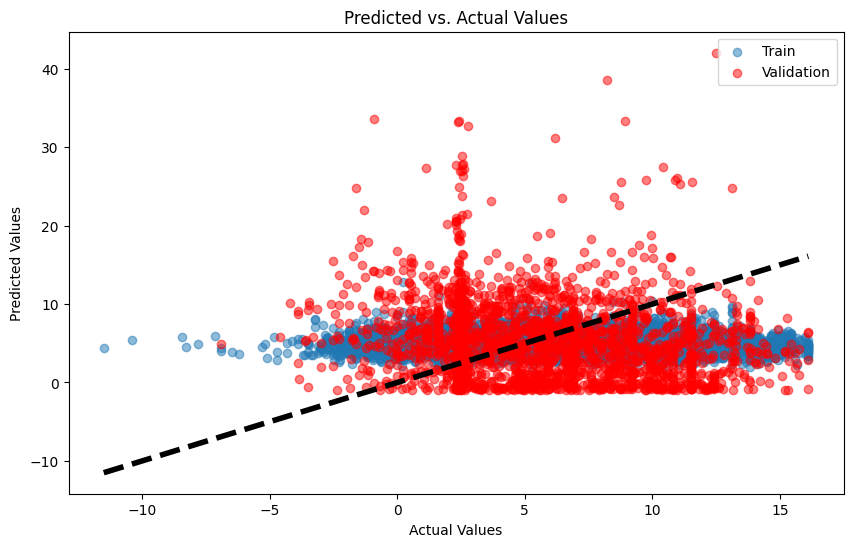

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(train_targets.numpy(), train_preds.numpy(), alpha=0.5, label='Train')
plt.scatter(val_targets.numpy(), val_preds.numpy(), color='red', alpha=0.5, label='Validation')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.plot([train_targets.min(), train_targets.max()], [train_targets.min(), train_targets.max()], 'k--', lw=4)
plt.show()


In [14]:
import pickle
with open('effectiveness_model_updated_final.pkl', 'wb') as f:
  pickle.dump(model, f)